In [1]:
import sys
sys.path.append('../')

from scripts.direct_training import direct_training
import matplotlib.pyplot as plt
from plotting_utils import style_defaults
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)

direct_df = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft"
    ),
    include_metadata=True,
).sort_values(by="n_train")

direct_df = direct_df[["n_train", "metadata_timing_training_duration", "test_force_rmse"]]
direct_df.columns = ["n_train", "duration", "test_force_rmse"]

direct_df

,n_train,duration,test_force_rmse
0,25,91.136917,1.329822
1,50,110.331766,1.182748
2,100,143.819512,1.074188
3,200,245.618072,0.971323
4,400,594.460129,0.907441
5,800,890.060217,0.836462
6,1600,2219.908514,0.770546
7,3200,9505.421192,0.707720


In [5]:
from scripts.fine_tuning import fine_tuning

pt_model = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        n_train=100_000,
        labels="ace"
    ),
).iloc[0].id

finetune_df = fine_tuning.to_dataframe(
    config=dict(
        pretrain_id=pt_model,
    ),
    include_metadata=True,
).sort_values(by="n_finetune")

finetune_df = finetune_df[["n_finetune", "metadata_timing_training_duration", "test_force_rmse"]]
finetune_df.columns = ["n_finetune", "duration", "test_force_rmse"]

finetune_df

,n_finetune,duration,test_force_rmse
0,25,35.336251,0.841699
1,50,37.589289,0.818326
2,100,56.698589,0.785320
3,200,98.617574,0.758818
4,400,182.246408,0.738471
5,800,373.184065,0.719071
6,1600,849.403731,0.702190
7,3200,1859.107319,0.680747


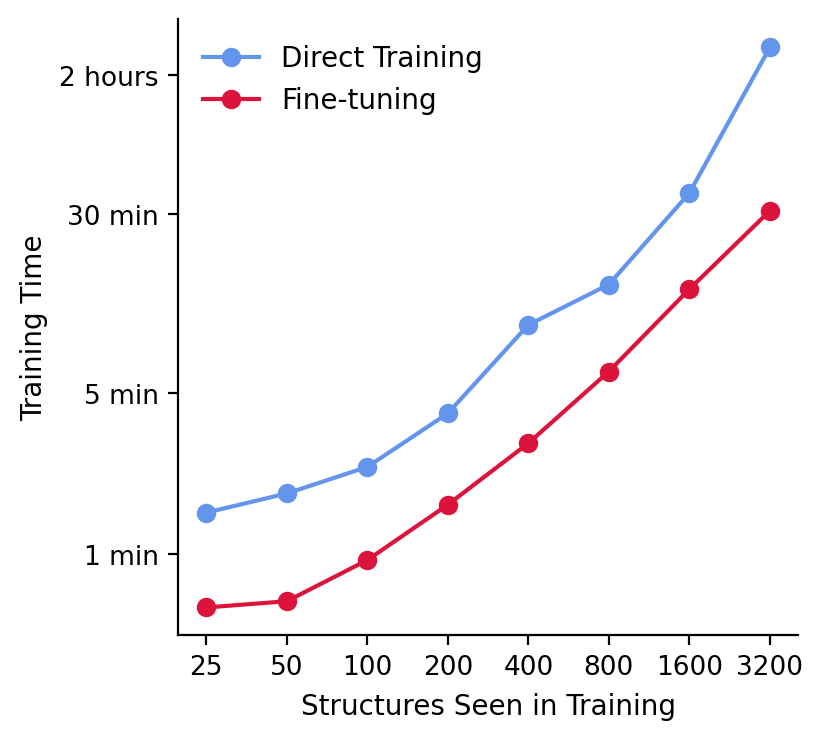

In [6]:
plt.plot(
    direct_df.n_train,
    direct_df.duration / 60,
    "-o",
    c="cornflowerblue",
    label="Direct Training"
)

plt.plot(
    finetune_df.n_finetune,
    finetune_df.duration / 60,
    "-o",
    c="crimson",
    label="Fine-tuning"
)
plt.xscale("log")
plt.xticks(finetune_df.n_finetune, finetune_df.n_finetune)
plt.xlabel("Structures Seen in Training")

yticks = [1, 5, 30, 120]
plt.yscale("log")
plt.yticks(yticks, ["1 min", "5 min", "30 min", "2 hours"])
plt.ylabel("Training Time")

plt.legend()
plt.minorticks_off()

In [3]:
speedup = (direct_df.duration / finetune_df.duration).mean()


f"On average, fine-tuning provides a {speedup:.1f}x speedup over direct training."

'On average, fine-tuning provides a 3.0x speedup over direct training.'

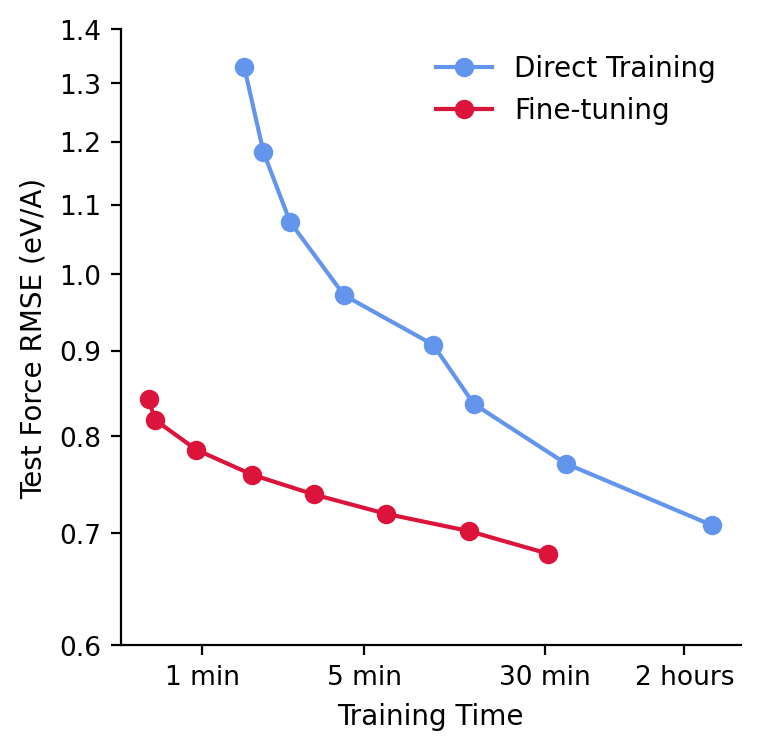

In [4]:
# also plot speed of training vs accuracy

plt.plot(
    direct_df.duration / 60,
    direct_df.test_force_rmse,
    "-o",
    c="cornflowerblue",
    label="Direct Training"
)

plt.plot(
    finetune_df.duration / 60,
    finetune_df.test_force_rmse,
    "-o",
    c="crimson",
    label="Fine-tuning"
)

plt.xscale("log")
plt.xticks([1, 5, 30, 120], ["1 min", "5 min", "30 min", "2 hours"])

yticks = [round(y, 1) for y in plt.yticks()[0]]
plt.yscale("log")
plt.yticks(yticks, yticks)

plt.xlabel("Training Time")
plt.ylabel("Test Force RMSE (eV/A)")
plt.legend()
plt.minorticks_off()